In [1]:
from new_attempt.stateless import *

In [2]:
import numpy as np

In [3]:
import inspect

In [4]:
from matplotlib import pyplot as plt

In [5]:
preliminaryData = createPreliminaryData(3)

In [7]:
regionFunctions = generateRegionFunctions(preliminaryData)

In [21]:
def matchesToIdentifiers(expression, pattern): 
    matches = list(expression.find(pattern))
    return {match : symbolicToIdentifier(match) for match in matches}


In [24]:
def lambdifyWaveFunction(amplitudeCoefficientEquations : dict, position : sp.Symbol) -> dict: 
    unconstrainedParticularSolution = amplitudeCoefficientEquations["unconstrainedParticularSolution"]
    harmonicConstant = unconstrainedParticularSolution["amplitudes"]["harmonicConstant"]
    amplitudeCoefficients = list(amplitudeCoefficientEquations["extrapolatedComponentsOfConstants"].keys())
    exponential = unconstrainedParticularSolution["expandedExponential"]
    functionSymbol = unconstrainedParticularSolution["exponential"].lhs.func
    conjugatedAmplitudeConstants = matchesToIdentifiers(
            exponential, 
            sp.conjugate(sp.Wild("C"))
        )
    sanitizedFunction = substituteIdentifierAtoms(
            exponential.subs(conjugatedAmplitudeConstants)
        )
    parameters = orderNames(
            list(conjugatedAmplitudeConstants.values()) \
                    + amplitudeCoefficients \
                    + [
                            symbolicToIdentifier(parameter) \
                            for parameter in [harmonicConstant, position]
                        ]
        )
    
    amplitudeCoefficientSubstitutionList = substituteIdentifierAtomsList(exponential)
    conjugateMap = {}
    print(amplitudeCoefficientSubstitutionList)
    for conjugateSymbolic, identifier in conjugatedAmplitudeConstants.items():
        cleanSymbol = conjugateSymbolic.args[0]
        conjugateMap[amplitudeCoefficientSubstitutionList[cleanSymbol]] = identifier
        
    functionIdentifier = symbolicToIdentifier(functionSymbol)
    baseNumericalFunction =  sp.lambdify(parameters, sanitizedFunction)
    def makeFunctionFromConstants(constants : dict) -> float: 
        amplitudeCoefficeintSolutions_ = {
                solutionSetName : solutions \
                for solutionSetName, solutions \
                        in constants["amplitudeConstants"].items() \
                if solutionSetName in amplitudeCoefficients
            }
        arguments = {}
        for solutionSetName, solutions in amplitudeCoefficeintSolutions_.items(): 
            if len(solutions) == 2: 
                arguments[solutionSetName] = solutions[0]
                arguments[conjugateMap[solutionSetName]] = solutions[1]
            else: 
                if type(solutions) is list: 
                    assert len(solutions) == 1, "makeExponentialWithConjugates: " \
                                                "inproper number of solutions (must be zero or one)" \
                                                "for amplitude coefficient!"
                    arguments[solutionSetName] = solutions[0]
                else: 
                    arguments[solutionSetName] = solutions
        harmonicConstantIdentifier = symbolicToIdentifier(harmonicConstant)
        arguments[harmonicConstantIdentifier] = constants["harmonicConstants"] \
                [harmonicConstantIdentifier]
        return lambda position_ : baseNumericalFunction(**(
                {symbolicToIdentifier(position) : position_} 
                | arguments
            ))
    return {
            "name" : functionIdentifier, 
            "functionFromConstantsBuilder" : makeFunctionFromConstants, 
            "parameters" : parameters, 
            "symbol" : functionSymbol, 
            "position" : position, 
            "harmonicConstant" : harmonicConstant, 
            "amplitudeCoefficientIdentifiers" : orderNames(amplitudeCoefficients), 
            "amplitudeConjugateCoefficientIdentifiers" : orderNames(list(
                    conjugatedAmplitudeConstants.values())
                ), 
        }

In [26]:
k_3 = 3

In [27]:
testBasicParameters = {
    "V_0" : 1, 
    "V_1" : 2, 
    "V_2" : 3, 
    "L_0" : 2, 
    "L_1" : 3, 
    "L_2" : 4, 
    "N_0" : .1, 
    "N_1" : .2, 
    "N_2" : .7, 
    "m" : 1, 
    "E_OCBtotalCCB" : .5, 
    "E_total" : .5, 
    "hbarX" : 1, 
    "k_3" : k_3, ###### FOR TESTING ONLY
    "L_N1" : 0, 
    "B_3" : 0
}

In [28]:
# Yoinked from computeSimulationConstants
harmonicConstants = {
        symbolicToIdentifier(functionData["equation"].lhs) 
                : computeHarmonicConstant(
                        functionData, 
                        testBasicParameters
                    ) \
        for functionData in regionFunctions["harmonicConstantFunctions"]
    }


In [29]:
harmonicConstants

{'k_0': 1.0000000000000002, 'k_1': 1.7320508075688772, 'k_2': 2.23606797749979}

In [30]:
harmonicConstants["k_3"] = k_3

In [ ]:
harmonicConstants

{'k_0': 1.0000000000000002,
 'k_1': 1.7320508075688772,
 'k_2': 2.23606797749979,
 'k_3': 3}

In [ ]:
trValues = {}
for trFunctions in regionFunctions["transmissionReflectionFunctions"]: 
    arguments = {parameter : harmonicConstants[parameter] for parameter in trFunctions["inputs"]}
    for name, calculator in trFunctions["computations"].items(): 
        trValues[name] = calculator(**arguments)

{'T_1_0': 1.2679491924311224,
 'R_1_0': 0.26794919243112253,
 'T_2_1': 1.1270166537925832,
 'R_2_1': 0.12701665379258317,
 'T_3_2': 1.1458980337503155,
 'R_3_2': 0.14589803375031543}

In [34]:
constants = computeSimulationConstants(preliminaryData, regionFunctions, testBasicParameters, 1, 1)

In [35]:
constants

{'harmonicConstants': {'k_0': 1.0000000000000002,
  'k_1': 1.7320508075688772,
  'k_2': 2.23606797749979},
 'transfers': [{'from': {'region': <new_attempt.stateless.RegionSymbols at 0x7fcbea05bb20>,
    'matrix': Matrix([
    [psi_2_t(L_1)],
    [psi_2_r(L_1)]])},
   'to': {'region': <new_attempt.stateless.RegionSymbols at 0x7fcbea05b6d0>,
    'matrix': Matrix([
    [psi_3_t(L_2)],
    [psi_3_r(L_2)]])},
   'transferValues': {'psi_3_tOPL_2CP': 1, 'psi_3_rOPL_2CP': 1}},
  {'from': {'region': <new_attempt.stateless.RegionSymbols at 0x7fcbea05bb20>,
    'matrix': Matrix([
    [psi_2_t(L_1)],
    [psi_2_r(L_1)]])},
   'to': {'region': <new_attempt.stateless.RegionSymbols at 0x7fcbea05b6d0>,
    'matrix': Matrix([
    [psi_3_t(L_2)],
    [psi_3_r(L_2)]])},
   'transferValues': {'psi_2_tOPL_1CP': 1.2909944487358058,
    'psi_2_rOPL_1CP': 0.5773502691896257}},
  {'from': {'region': <new_attempt.stateless.RegionSymbols at 0x7fcbea05b6d0>,
    'matrix': Matrix([
    [psi_1_t(L_0)],
    [psi_1_r

In [36]:
waveFunctionGenerators = [
            lambdifyWaveFunction(function["amplitudeCoefficientEquations"], POSITION_SYMBOL)
            for function in regionFunctions["amplitudeConstantFunctions"]
    ]

{C_{{0}_t}: 'C_OCBOCB0CCB_tCCB', C_{{0}_r}: 'C_OCBOCB0CCB_rCCB', x: 'x', k_0: 'k_0'}
{k_1: 'k_1', x: 'x', C_{{1}_r}: 'C_OCBOCB1CCB_rCCB', C_{{1}_t}: 'C_OCBOCB1CCB_tCCB'}
{x: 'x', C_{{2}_r}: 'C_OCBOCB2CCB_rCCB', k_2: 'k_2', C_{{2}_t}: 'C_OCBOCB2CCB_tCCB'}


In [37]:
waveFunctions = [
        generator["functionFromConstantsBuilder"](constants) \
        for generator in waveFunctionGenerators
    ]

In [38]:
waveFunctions

[<function __main__.lambdifyWaveFunction.<locals>.makeFunctionFromConstants.<locals>.<lambda>(position_)>,
 <function __main__.lambdifyWaveFunction.<locals>.makeFunctionFromConstants.<locals>.<lambda>(position_)>,
 <function __main__.lambdifyWaveFunction.<locals>.makeFunctionFromConstants.<locals>.<lambda>(position_)>]

In [39]:
L_N1 = testBasicParameters["L_N1"]
L_0 = testBasicParameters["L_0"]
L_1 = testBasicParameters["L_1"]
L_2 = testBasicParameters["L_2"]
resolution = .01

In [40]:
domains = [
        np.arange(L_N1, L_0, resolution), 
        np.arange(L_0, L_1, resolution), 
        np.arange(L_1, L_2, resolution)
    ]

In [41]:
waveFunctionProbabilities = [
        waveFunctions[ii](domains[ii])
        for ii in range(len(waveFunctions))
    ]

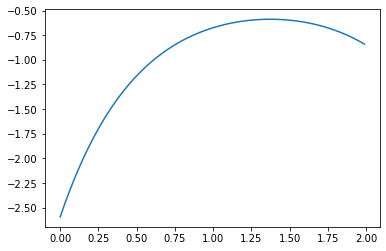

In [42]:
plt.plot(domains[0], waveFunctionProbabilities[0])

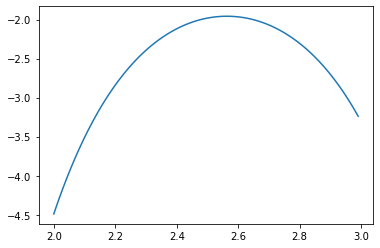

In [43]:
plt.plot(domains[1], waveFunctionProbabilities[1])

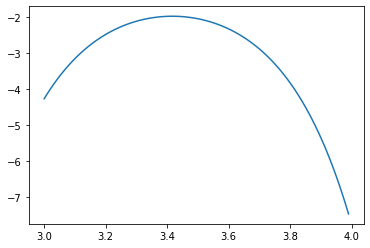

In [44]:
plt.plot(domains[2], waveFunctionProbabilities[2])

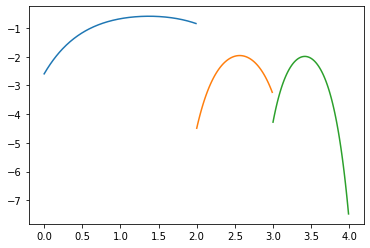

In [45]:
for ii in range(len(waveFunctionProbabilities)): 
    plt.plot(domains[ii], waveFunctionProbabilities[ii])

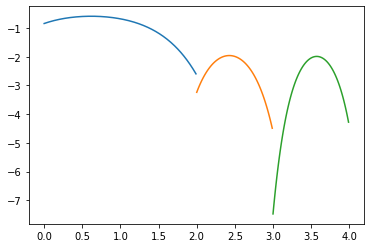

In [46]:
for ii in range(len(waveFunctionProbabilities)): 
    plt.plot(domains[ii], list(reversed(waveFunctionProbabilities[ii])))